Welcome to the `TOTO-tDCS` jupyter Notebook!

Today we will be presenting the results of the [Memory Modulation Lab](http://www.thememolab.org/)'s `TOTO-tDCS` experiment, analyzed using [Quail](http://cdl-quail.readthedocs.io/en/latest/) and Python 2.7.

# Load in libraries

Let us begin be importing the python modules we will be using.

In [1]:
import glob # for matching filenames using wildcards
import re # regular expressions
import pandas as pd # a tidyverse esq python data manipulation package
import quail as q # andy's free recall package
import numpy as np # arrary manipulation
import math
from scipy import stats # python statistics
import os

# Read in Data

Next, lets read in the `TOTO-tDCS` data and load it into the `Quail` package!

We will read in the data (currently as .tsv (study) and .csv (recall) files) using pandas' `read_csv` method.

## Study

First, the study phase.

In [2]:
# a custom function for reading in the study data
def read_and_extract_study(f):
        
    # read in file
    tmp = pd.read_csv(f, sep = "\t")

    return tmp

In [3]:
# get filenames using glob
path = '/Volumes/GoogleDrive/My Drive/Behavioral Data/TOTO-tDCS/sub-s*/ses-01/*/' # where the data is on Kyle's Desktop
filenames = glob.glob(path + "*.tsv") # filenames selected using wildcards

# read in using pandas
study = pd.concat((read_and_extract_study(f) for f in filenames)) # read and concatenate
study.head() # head

,subjectID,roundID,listID,Word,Arousal,Valence,EmotionCategory,Condition,ExpOnset,RoundOnset,ListOnset,resp,resp_time,rt
0,s001,1,3,SNORKEL,5.12,5.72,Neutral,allNeutral,9.959198,3.645907,2.532931,2@,3.437379,0.904447
1,s001,1,3,DAM,4.96,5.15,Neutral,allNeutral,14.510805,8.197514,7.084538,2@,7.844745,0.760207
2,s001,1,3,NUCLEUS,4.88,5.47,Neutral,allNeutral,19.062287,12.748995,11.636020,1!,12.214062,0.578042
3,s001,1,3,ATOM,5.22,5.59,Neutral,allNeutral,23.613931,17.300639,16.187664,1!,16.812988,0.625325
4,s001,1,3,SUITCASE,4.93,5.36,Neutral,allNeutral,28.165212,21.851920,20.738945,2@,21.780525,1.041580


## Recall

Second, recall. We need to extract the subjectIDs and listIDs from the filenames.

In [10]:
# a custom function for reading and extracting useful information from filenames
def read_and_extract(f):
    
    # read in file
    tmp = pd.read_csv(filepath_or_buffer = f, skip_blank_lines = True)
    
    # add subjectID column
    p = re.compile('sub-[ps]\d\d\d') # regular expression pattern object
    m = p.search(f) # a match object
    match = m.group() # actual match
    match = re.search('[ps]\d\d\d', match).group() # just the p/s### part
    tmp['subjectID'] = match # assign subjectID the matches
    
    # add listID column
    p = re.compile('list-\d\d?_') # regular expression pattern object
    m = p.search(f) # a match object
    match = m.group() # actual match
    match = re.search('[1-9]?\d(?=_)', match).group() # match without the '_'s
    tmp['listID'] = match # assign listID the match
    
    return tmp

In [11]:
# get filenames using glob
path = '/Volumes/GoogleDrive/My Drive/Behavioral Data/TOTO-tDCS/derivatives/penntotalrecall/sub-s0*/ses-01/' # where the data is on Kyle's Desktop
filenames = glob.glob(path + "*.csv") # filenames selected using wildcards

# read in using pandas
recall = pd.concat((read_and_extract(f) for f in filenames)) # read and concatenate
recall.head() # head

,Unnamed: 0,emily,endTime,listID,startTime,subjectID,word
0,1.0,pick,2s,1,1.500s,s001,check
1,2.0,stairs,3.100s,1,2s,s001,stairs
2,3.0,seal,4.300s,1,3.100s,s001,seal
3,4.0,lettuce,5.400s,1,4.300s,s001,lettuce
4,5.0,rattle,7s,1,5.400s,s001,rattle


# Data Preperation

Next, lets create a Quail `egg`. An `egg` is a specialized data structure used by the quail package.

Eggs are created from nested python lists. We need to first write some code to turn our PANDAS data.frames to lists of lists.

In [12]:
# Goal: turn `study` data.frame into a lists of lists

# initialize two variables `presented_words` and `presented_word_features`, which will be used to create the egg.
presented_words = []
presented_word_features = []

# for each subject...
for s in study['subjectID'].unique():
    
    # all of the data related to the current subject
    cur_sub = study[study['subjectID'] == s]
    
    # initalizing temporary variables to hold the words on this list and the features of the words on this list
    lists = []
    lists_features = []
    
    # for each list...
    for l in cur_sub['listID'].unique():
        
        # current list subset of cur_sub data.frame
        cur_list = cur_sub[cur_sub['listID'] == l]
        
        # the words presented on this list
        words = list(cur_list['Word'])
        
        # force lowercase
        words = map(str.lower, words)
        
        # append
        lists.append(words)
        lists_features.append(cur_list[['EmotionCategory']].to_dict(orient='records'))
    
    # append
    presented_words.append(lists)
    presented_word_features.append(lists_features)

In [30]:
# Goal: turn `recall` data.frame into a lists of lists. Note: must match the order of the `study` data.frame

# initalize a list of recalled words
recalled_words = []

# for each subject...
for s in study['subjectID'].unique():
    
    # the current subject's encoding (or study) data
    cur_sub = study[study['subjectID'] == s]
    
    # initialize a temporary variable to hold the recalled words
    lists = []
    
    # for each list from **encoding/study**...
    for l in cur_sub['listID'].unique():
        
        # the current list from **recall**
        cur_list = recall[np.array(recall['listID'] == str(l)) & np.array(recall['subjectID'] == s)]
        
        # words recalled from this list for this subject
        words = cur_list.iloc[:, 1].tolist()
        
        # remove the "unknown" words
        while 'UNKNOWN' in words:
            words.remove('UNKNOWN')
            
        # remove tildes (~) in words
        while '~' in words:
            words.remove('~')
            
        # remove question marks (?) in words
        while '?' in words:
            words.remove('?')
            
        # remove nans
        c = -1
        for w in words:
            c = c + 1            
            if type(w) != str:
                words[c] = ''
        
        # force the words to be lowercase and append
        lists.append(map(str.lower, words))
        
    # append
    recalled_words.append(lists)

In [51]:
# create an egg
egg = q.Egg(pres=presented_words, rec=recalled_words, features=presented_word_features)

# remove subjects who haven't been scored yet
egg = q.crack_egg(egg, subjects=range(18))

# information about the egg
egg.info()

Number of subjects: 18
Number of lists per subject: 16
Number of words per list: 16
Date created: Wed Jun 20 10:48:20 2018
Meta data: {}


In [52]:
# presented words
egg.pres.head()

0         1        2         3         4        5   \
Subject List                                                               
0       0        snorkel       dam  nucleus      atom  suitcase     dill   
        1         rattle    crater   mister  electron   earring   collar   
        2            elf  blockade    thorn       cap      acid     wick   
        3     department    marrow  thimble   console    trench    xerox   
        4           bomb      bush  convict   suspect     crown  hatchet   

                   6         7            8        9          10        11  \
Subject List                                                                 
0       0      jungle   aspirin  caterpillar     coat     keeper      beet   
        1     lettuce     dryer   instructor      pig  newspaper  mushroom   
        2      inmate     stool       bullet     sack   magazine     crook   
        3     tourist  monument     producer   heater      pluto  doorbell   
        4        wasp    needle         cage  captive     racket     pedal   

                   12          13     14            15  
Subject List                                            
0       0      tunnel        body  arrow  handkerchief  
        1        heel      mirror   pick        stairs  
        2     vagrant       ulcer   lens       stapler  
        3        ship       clown  fence     polyester  
        4       stamp  supervisor  onion        lizard

In [53]:
# recalled words
egg.rec.head()

0         1         2        3           4           5   \
Subject List                                                                   
0       0       snorkle    keeper      atom  nucleus        dill        body   
        1          pick    stairs      seal  lettuce      rattle  instructor   
        2         ulcer       elf   stapler   inmate       ulcer         cap   
        3     polyester  monument  producer   heater       pluto       clown   
        4        lizard      bomb      bush  convict  supervisor      needle   

                  6         7     8       9  ...    14   15   16   17   18  \
Subject List                                 ...                             
0       0     tunnel      beet  coat    None ...   NaN  NaN  NaN  NaN  NaN   
        1     mirror  mushroom  pick  mister ...   NaN  NaN  NaN  NaN  NaN   
        2       wick   vagrant  None    None ...   NaN  NaN  NaN  NaN  NaN   
        3     trench     xerox  None    None ...   NaN  NaN  NaN  NaN  NaN   
        4       wasp   capture  None    None ...   NaN  NaN  NaN  NaN  NaN   

               19   20   21   22   23  
Subject List                           
0       0     NaN  NaN  NaN  NaN  NaN  
        1     NaN  NaN  NaN  NaN  NaN  
        2     NaN  NaN  NaN  NaN  NaN  
        3     NaN  NaN  NaN  NaN  NaN  
        4     NaN  NaN  NaN  NaN  NaN  

[5 rows x 24 columns]

In [54]:
# word features. the only feature we currently have is negative/neutral
egg.features.head()

0   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2       {u'EmotionCategory': u'Neutral'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Emotional'}   

                                              1   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Emotional'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                              2   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Emotional'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Emotional'}   

                                              3   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2       {u'EmotionCategory': u'Neutral'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Emotional'}   

                                              4   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Emotional'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                              5   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2       {u'EmotionCategory': u'Neutral'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Emotional'}   

                                              6   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Emotional'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Emotional'}   

                                              7   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2       {u'EmotionCategory': u'Neutral'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Emotional'}   

                                              8   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Emotional'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Emotional'}   

                                              9   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2       {u'EmotionCategory': u'Neutral'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Emotional'}   

                                            10  \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                             

# Analysis

Let's run some analyses.

## Recall Accuracy

The total percentage of presented words that were successfully recalled as a function of Subject.

In [55]:
recall_accuracy = q.analyze(egg, analysis='accuracy')
recall_accuracy.head()

0
Subject List        
0       0     0.5000
        1     0.5000
        2     0.4375
        3     0.5000
        4     0.4375

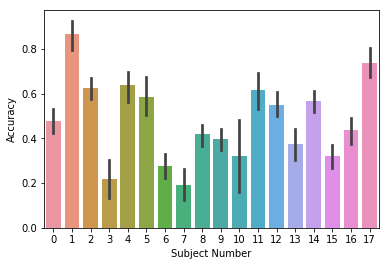

In [56]:
ax = q.plot(recall_accuracy, plot_type='subject', subjname='Subject Number')

## Serial Position Curve

The proportion of words recalled as a function of list position and list composition.

In [78]:
spc = q.analyze(egg, analysis='spc', listgroup=['mean']*16)
spc.head()

,,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,mean,0.562500,0.2500,0.562500,0.312500,0.3125,0.500000,0.625000,0.312500,0.437500,0.625000,...,0.437500,0.875000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,mean,0.875000,0.8750,0.812500,0.875000,0.8750,0.812500,0.812500,0.812500,1.000000,0.875000,...,0.875000,0.937500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,mean,0.812500,0.5625,0.750000,0.562500,0.5625,0.500000,0.625000,0.500000,0.437500,0.562500,...,0.625000,0.937500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,mean,0.166667,0.0000,0.166667,0.166667,0.2500,0.083333,0.166667,0.166667,0.166667,0.166667,...,0.416667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,mean,0.937500,0.8125,0.687500,0.812500,0.6875,0.562500,0.750000,0.500000,0.437500,0.562500,...,0.750000,0.687500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


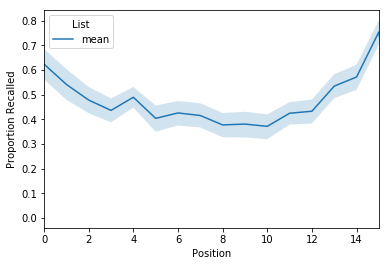

In [79]:
ax = q.plot(spc)

## Probability of First Recall

The probability of recalling a given word first as a function of word position and list composition.

In [80]:
pfr = q.analyze(egg, analysis='pfr', listgroup=['mean']*16)
pfr.head()

,,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,mean,0.1250,0.0000,0.062500,0.0000,0.000000,0.0,0.0,0.0000,0.0,0.000000,...,0.1250,0.312500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,mean,0.1250,0.0625,0.000000,0.0000,0.000000,0.0,0.0,0.0000,0.0,0.000000,...,0.0625,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,mean,0.0625,0.0000,0.000000,0.0625,0.062500,0.0,0.0,0.0625,0.0,0.000000,...,0.0000,0.687500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,mean,0.0000,0.0000,0.083333,0.0000,0.083333,0.0,0.0,0.0000,0.0,0.083333,...,0.0000,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,mean,0.3125,0.0625,0.062500,0.0625,0.000000,0.0,0.0,0.0625,0.0,0.000000,...,0.1250,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


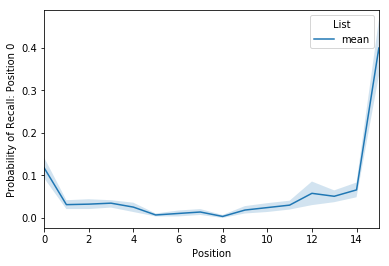

In [81]:
ax = q.plot(pfr)

## Lag-CRP

The conditional recall probability as a function of position relative to the previous recall.

In [82]:
lagcrp = q.analyze(egg, analysis='lagcrp', listgroup=['mean']*16)
lagcrp.head()

,,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,...,7,8,9,10,11,12,13,14,15,16
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,mean,0.0,0.1250,0.00000,0.156250,0.000000,0.000000,0.028125,0.052083,0.054167,0.041667,...,0.093750,0.062500,0.000000,0.020833,0.020833,0.000000,0.0,0.0625,0.0625,0.0
1,mean,0.0,0.1875,0.03125,0.000000,0.000000,0.054167,0.000000,0.000000,0.015625,0.059003,...,0.015625,0.020833,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.0
2,mean,0.0,0.0625,0.12500,0.078125,0.083333,0.031250,0.028125,0.213542,0.015625,0.041667,...,0.031845,0.059375,0.104167,0.104167,0.015625,0.020833,0.0,0.0625,0.0000,0.0
3,mean,0.0,0.0000,0.00000,0.000000,0.027778,0.000000,0.000000,0.083333,0.041667,0.027778,...,0.111111,0.000000,0.166667,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.0
4,mean,0.0,0.0625,0.12500,0.031250,0.020833,0.106250,0.062500,0.127083,0.083333,0.031250,...,0.087500,0.043750,0.041667,0.052083,0.052083,0.083333,0.0,0.0000,0.0625,0.0


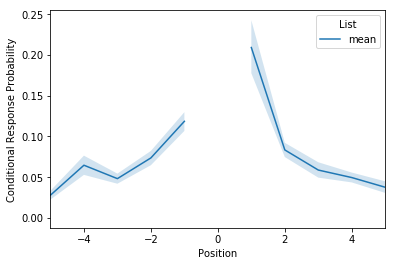

In [83]:
ax = q.plot(lagcrp)

## Temporal clustering

Temporal clustering score as a function of list composition.

Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)


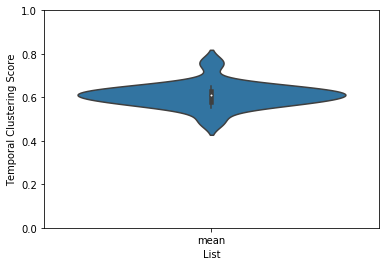

In [84]:
temporal = q.analyze(egg, analysis='temporal', listgroup=['mean']*16)
ax = q.plot(temporal, plot_style="violin" , ylim=[0,1])

In [71]:
# repeated measures ttest
t, p = stats.ttest_rel(temporal.xs('2', level='List'), temporal.xs('8', level='List'), nan_policy='omit')

# t and p values
print('Two Sided, repeated measures t-test of List(2/8):')
print('t-value: ' + str(t[0]))
print('p-value: ' + str(p[0]))

Two Sided, repeated measures t-test of List(2/8):
t-value: 0.0243433355845
p-value: 0.980862212957


## Memory Fingerprint

The likelihood subjects' clustered their recall around a particular word feature as a function of list composition.

In [85]:
fingerprint = q.analyze(egg, analysis='fingerprint', listgroup=['mean']*16)
fingerprint.head()

Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)


,,EmotionCategory
Subject,List,
0,mean,0.554545
1,mean,0.549985
2,mean,0.541649
3,mean,NaN
4,mean,0.555585


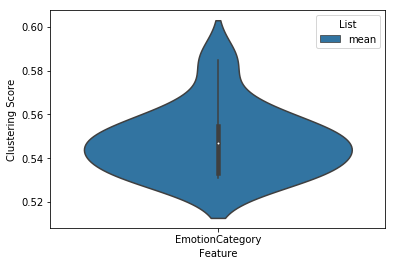

In [86]:
ax = q.plot(fingerprint)

In [87]:
# print the entire fingerprint dataframe
print(fingerprint)

# repeated measures ttest
t, p = stats.ttest_rel(fingerprint.xs('2', level='List'), fingerprint.xs('8', level='List'), nan_policy='omit')

# t and p values
print('Two Sided, repeated measures t-test of List(2/8):')
print('t: ' + str(t[0]))
print('p: ' + str(p))

              EmotionCategory
Subject List                 
0       mean         0.554545
1       mean         0.549985
2       mean         0.541649
3       mean              NaN
4       mean         0.555585
5       mean         0.543238
6       mean              NaN
7       mean              NaN
8       mean         0.546743
9       mean         0.533414
10      mean              NaN
11      mean         0.530939
12      mean         0.532770
13      mean              NaN
14      mean         0.532881
15      mean         0.564558
16      mean         0.548238
17      mean         0.584801


KeyError: '2'